In [ ]:
! pip install qiskit[visualization]
! pip install qiskit-ibm-runtime
! pip install qiskit-aer

In [ ]:
# macOSの場合
! brew install graphviz

In [ ]:
# 2
# 各種ライブラリをimportします
import matplotlib.pyplot as plt
import time
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import transpile
from qiskit.circuit.library import MCXGate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

# 量子コンピューティング1A 第5回　NISQ1
今回の演習では現代の量子計算機の最も重要な課題であるノイズに関して学びます。

今回の演習ではQiskit　Aer simulator、ノイズ付きシミュレータ、量子コンピュータ実機を使います。IBM Quantum のユーザ登録をしてください。また、実機は量子回路のジョブキューが長い場合はすぐに実行できるとは限らないので、余裕を持って課題を実行してください。

In [ ]:
token = "YOUR_API_TOKEN"

In [3]:
token="2682c31f228ad5f7296bcfb0379f1ebb361c550c119f373705ba2cbb3c54635fb8df43d97bbd2e2fde07ac8d56fde89eb8b7bfe08191666258848f952ed90477"

In [81]:
# <MY_IBM_QUANTUM_TOKEN>を自分のAPIトークンで置き換えて実行してください。
service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q/open/main", token=token
)

/var/folders/fs/m5091v096zz6c0gfp0x8s9sm0000gn/T/ipykernel_66323/340948962.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


In [82]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=2)
print(f"Using backend: {backend}")

Using backend: <IBMBackend('ibm_sherbrooke')>


In [27]:
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)

Name: ibm_brisbane
Version: 2
No. of qubits: 127



In [ ]:
backend.qubit_properties(0)  # properties of qubit 0

QubitProperties(t1=0.00023736364020705798, t2=3.911351782607003e-05, frequency=4721907253.805372)

In [4]:
# 3
def run_qc_on_aer(qc):
  # Qiskit Aer Simulatorを使用して量子回路を実行
  simulator = AerSimulator()
  print(f"Using backend:" + "AerSimulator")
  compiled_circuit = transpile(qc, simulator)
  result = simulator.run(compiled_circuit).result()
  counts = result.get_counts()
  return counts

In [41]:
def run_qc_on_noised_simulator(qc, backend):
  # Qiskit Aer Simulatorを使用して量子回路を実行
    print(f"Using fakce backend: {backend.name}") 
    noise_model = NoiseModel.from_backend(backend)
    simulator = AerSimulator(noise_model=noise_model)
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    counts = result.get_counts()
    return counts

In [93]:
def run_qc_on_ibmq(qc, backend):
    # バックエンドの名前を表示
    print(f"Using backend: {backend.name}")
    
    # 回路をトランスパイル
    transpiled_circuit = transpile(qc, backend=backend, optimization_level=0)
    
    # Samplerインスタンス生成
    sampler = Sampler(backend)
    sampler.options.default_shots = 1000
    
    # 実行と結果取得
    job = sampler.run([transpiled_circuit])
    result = job.result()[0]
    counts = result.join_data().get_counts()
    return counts

In [ ]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

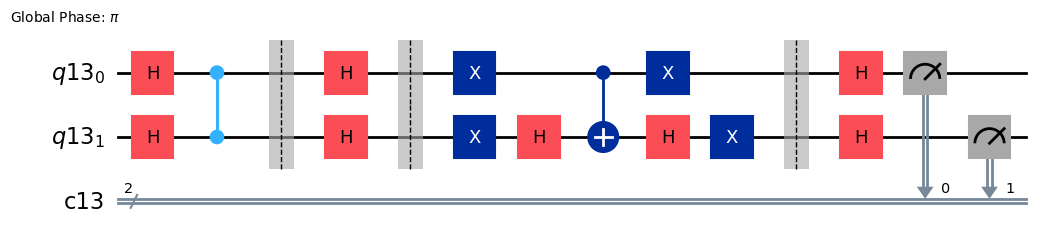

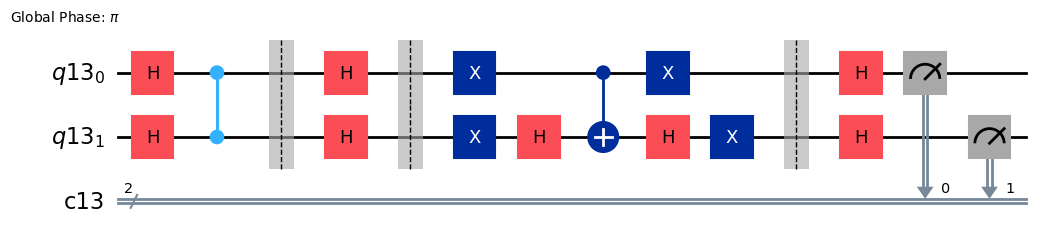

In [133]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import grover_operator
from qiskit.circuit.library import MCXGate

num_qubits = 2
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits) 
qc = QuantumCircuit(qr, cr)

# initialize 
qc.h(qr[:])
# phase oracle
# mcx = MCXGate(num_qubits-1)
# qc.append(mcx, qr[:])  # search |10>

qc.cz(qr[0],qr[1])  # search |11>
# inversion about average
qc = grover_operator(qc, insert_barriers=True)
qc.measure(qr[:], cr[:])
qc.draw("mpl")

In [134]:
aer_counts = run_qc_on_aer(qc)
noised_aer_counts = run_qc_on_noised_simulator(qc, backend)     
ibmq_counts = run_qc_on_ibmq(qc, backend)

Using backend:AerSimulator
Using fakce backend: ibm_sherbrooke
Using backend: ibm_sherbrooke


In [95]:
def plot_multiple_counts(counts_list, labels=None, title="Measurement Results"):
    """
    複数のcounts辞書を重ねてヒストグラムで表示する。
    
    Parameters:
    - counts_list: list of dict
        Qiskit実行結果のcounts（辞書）を複数渡す。
    - labels: list of str, optional
        各countsに対応するラベル。
    - title: str
        図のタイトル。
    """
    if labels is None:
        labels = [f"Run {i+1}" for i in range(len(counts_list))]

    if len(labels) != len(counts_list):
        raise ValueError("labelsの数がcounts_listと一致していません。")

    plot_histogram(counts_list, legend=labels, title=title)
    plt.show()

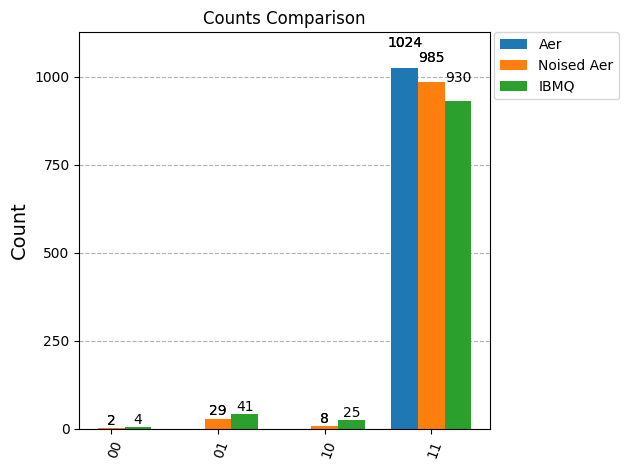

In [135]:
%matplotlib inline
plot_multiple_counts([aer_counts, noised_aer_counts, ibmq_counts], labels=["Aer", "Noised Aer", "IBMQ"], title="Counts Comparison")

In [22]:
service.backends()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]

In [23]:
# 利用可能なバックエンドを取得
get_backends = service.backends()

In [24]:
service.backends(simulator=False, operational=True, min_num_qubits=5)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]

In [ ]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=2)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = Sampler(backend)
sampler.options.default_shots = 1_000
job = sampler.run([isa_circuit])
result = job.result()

# 実行と結果取得
result = sampler.run([transpiled_qc]).result()
counts = result[0].data.meas.get_counts()

print("測定結果:", counts)

測定結果: {'00': 6, '11': 955, '10': 27, '01': 12}


In [ ]:


# 例：最適化レベル2の場合
optimization_level = 2
pass_manager = generate_preset_pass_manager(optimization_level=optimization_level)

# PassManager の内容を表示
print(pass_manager)

In [18]:
import graphviz
from graphviz import Digraph

In [ ]:
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import pass_manager_drawer

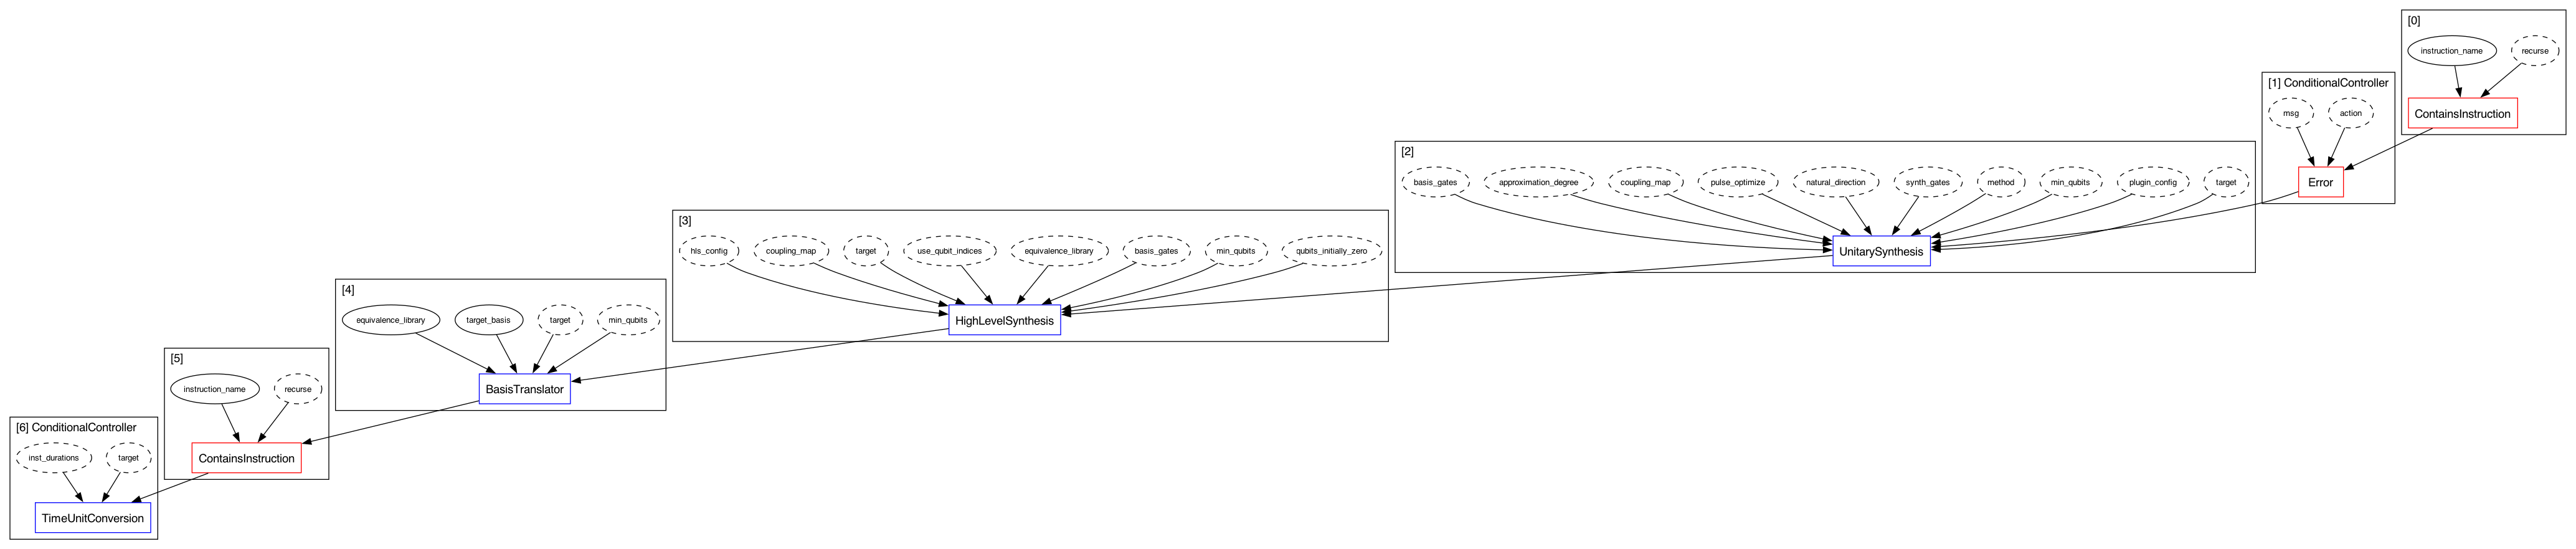

In [ ]:
pm = generate_preset_pass_manager(optimization_level=0)
pass_manager_drawer(pm)

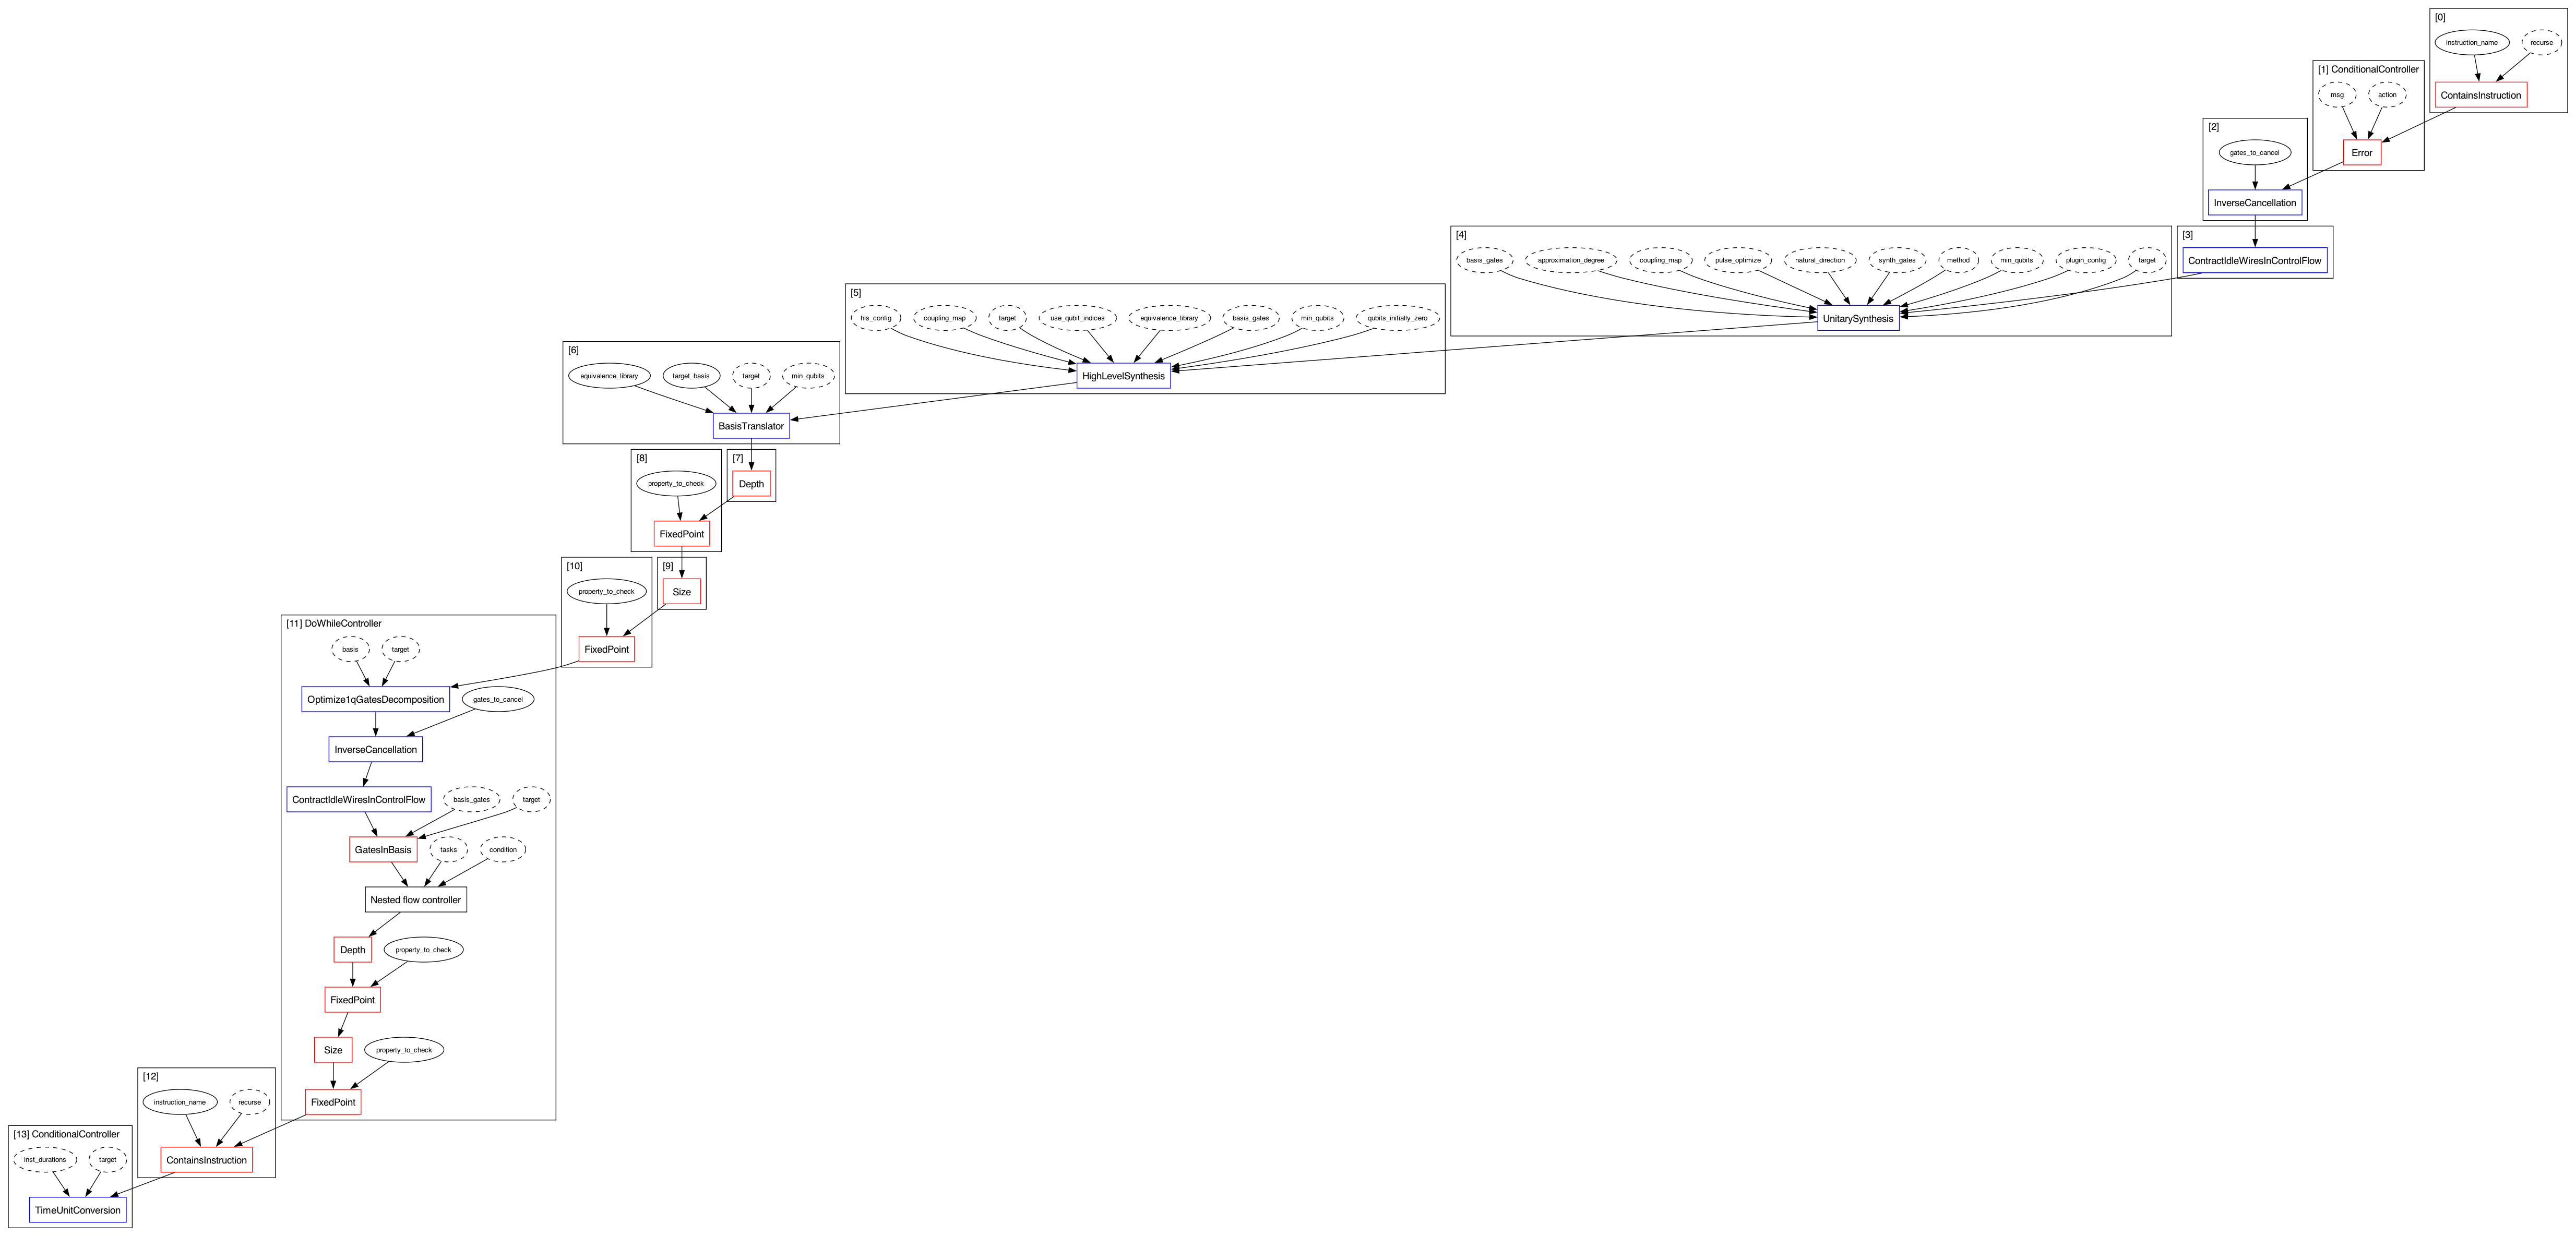

In [3]:
pm = generate_preset_pass_manager(optimization_level=1)
pass_manager_drawer(pm)

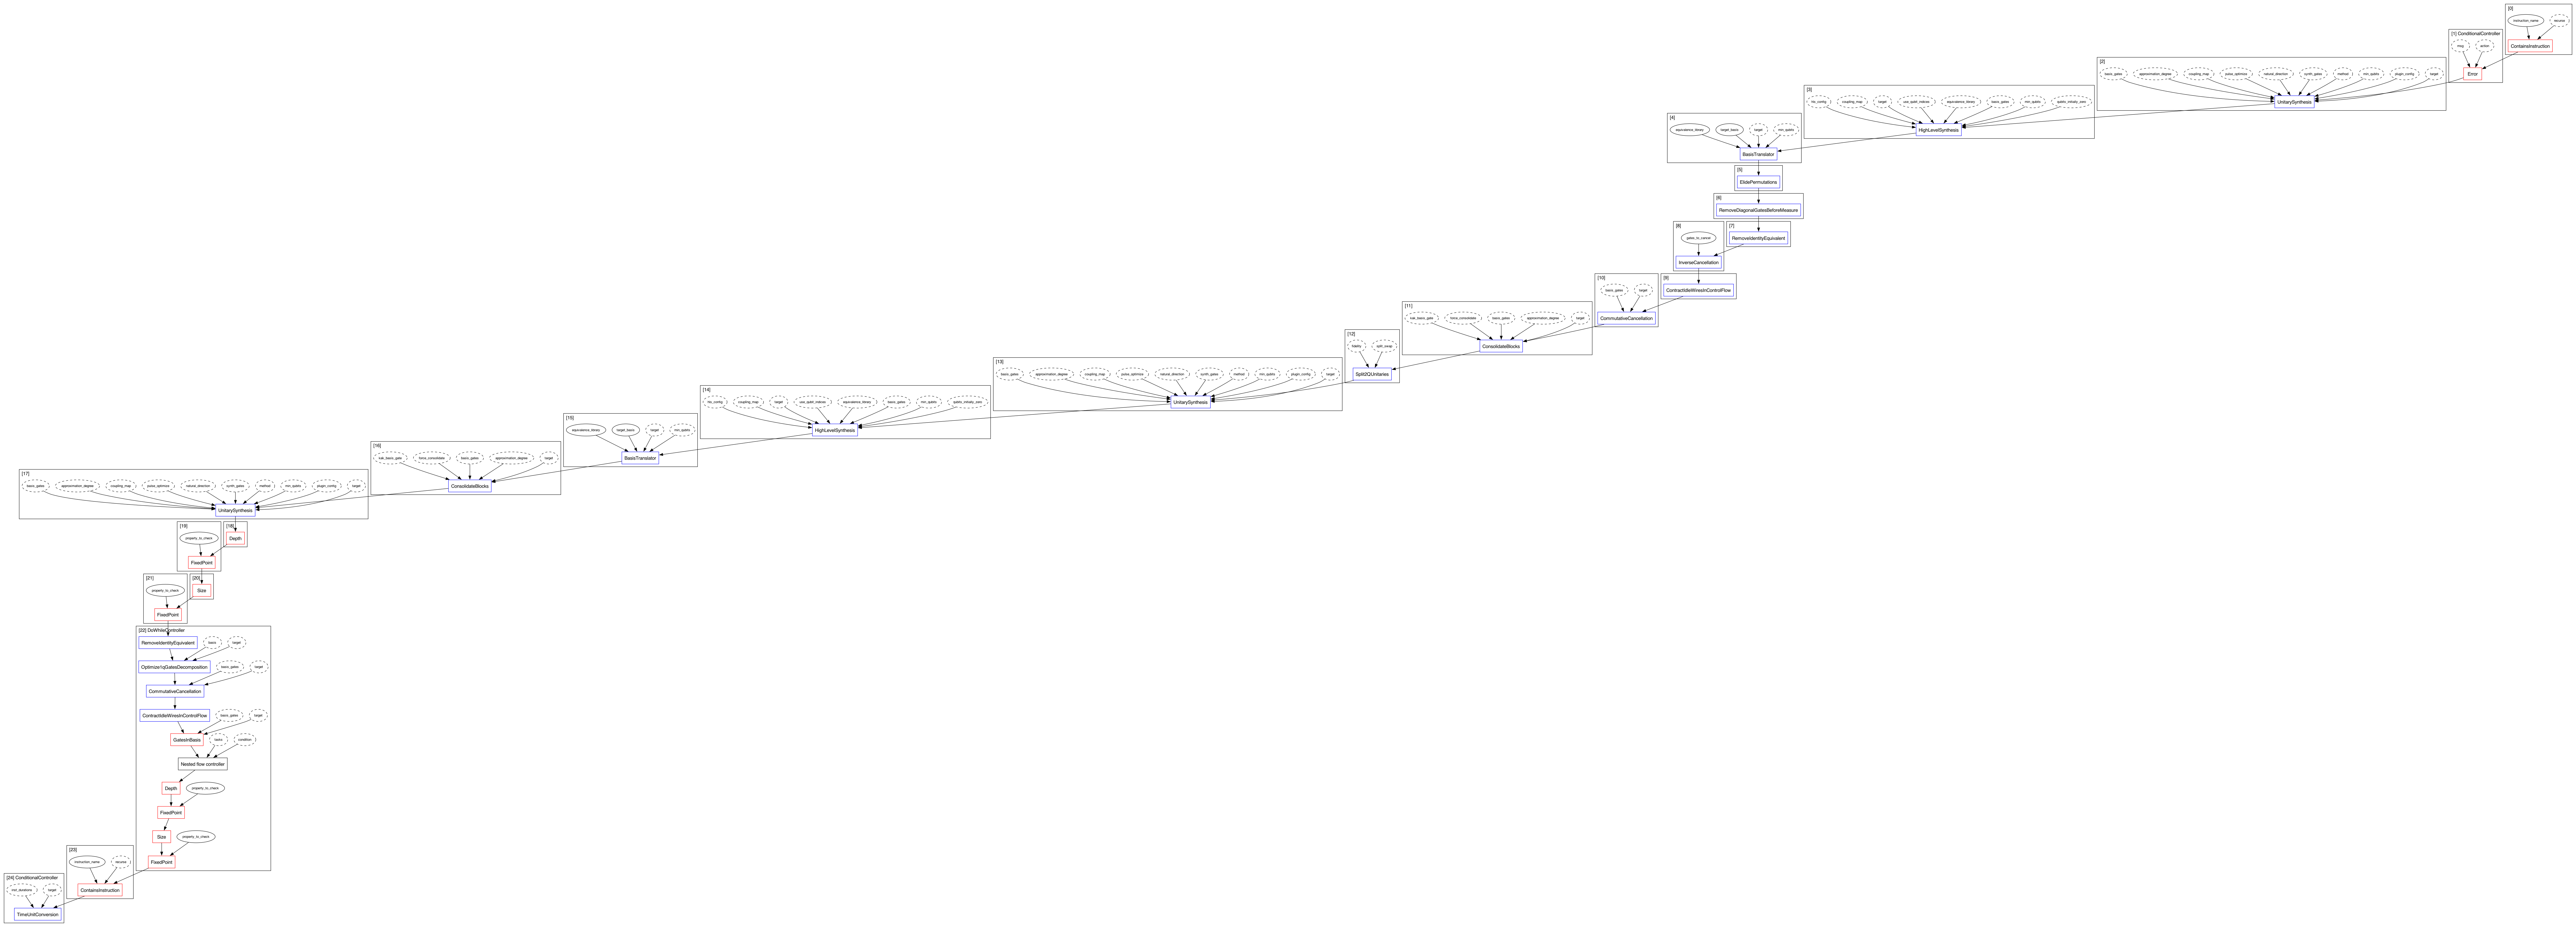

In [2]:
pm = generate_preset_pass_manager(optimization_level=2)
pass_manager_drawer(pm)

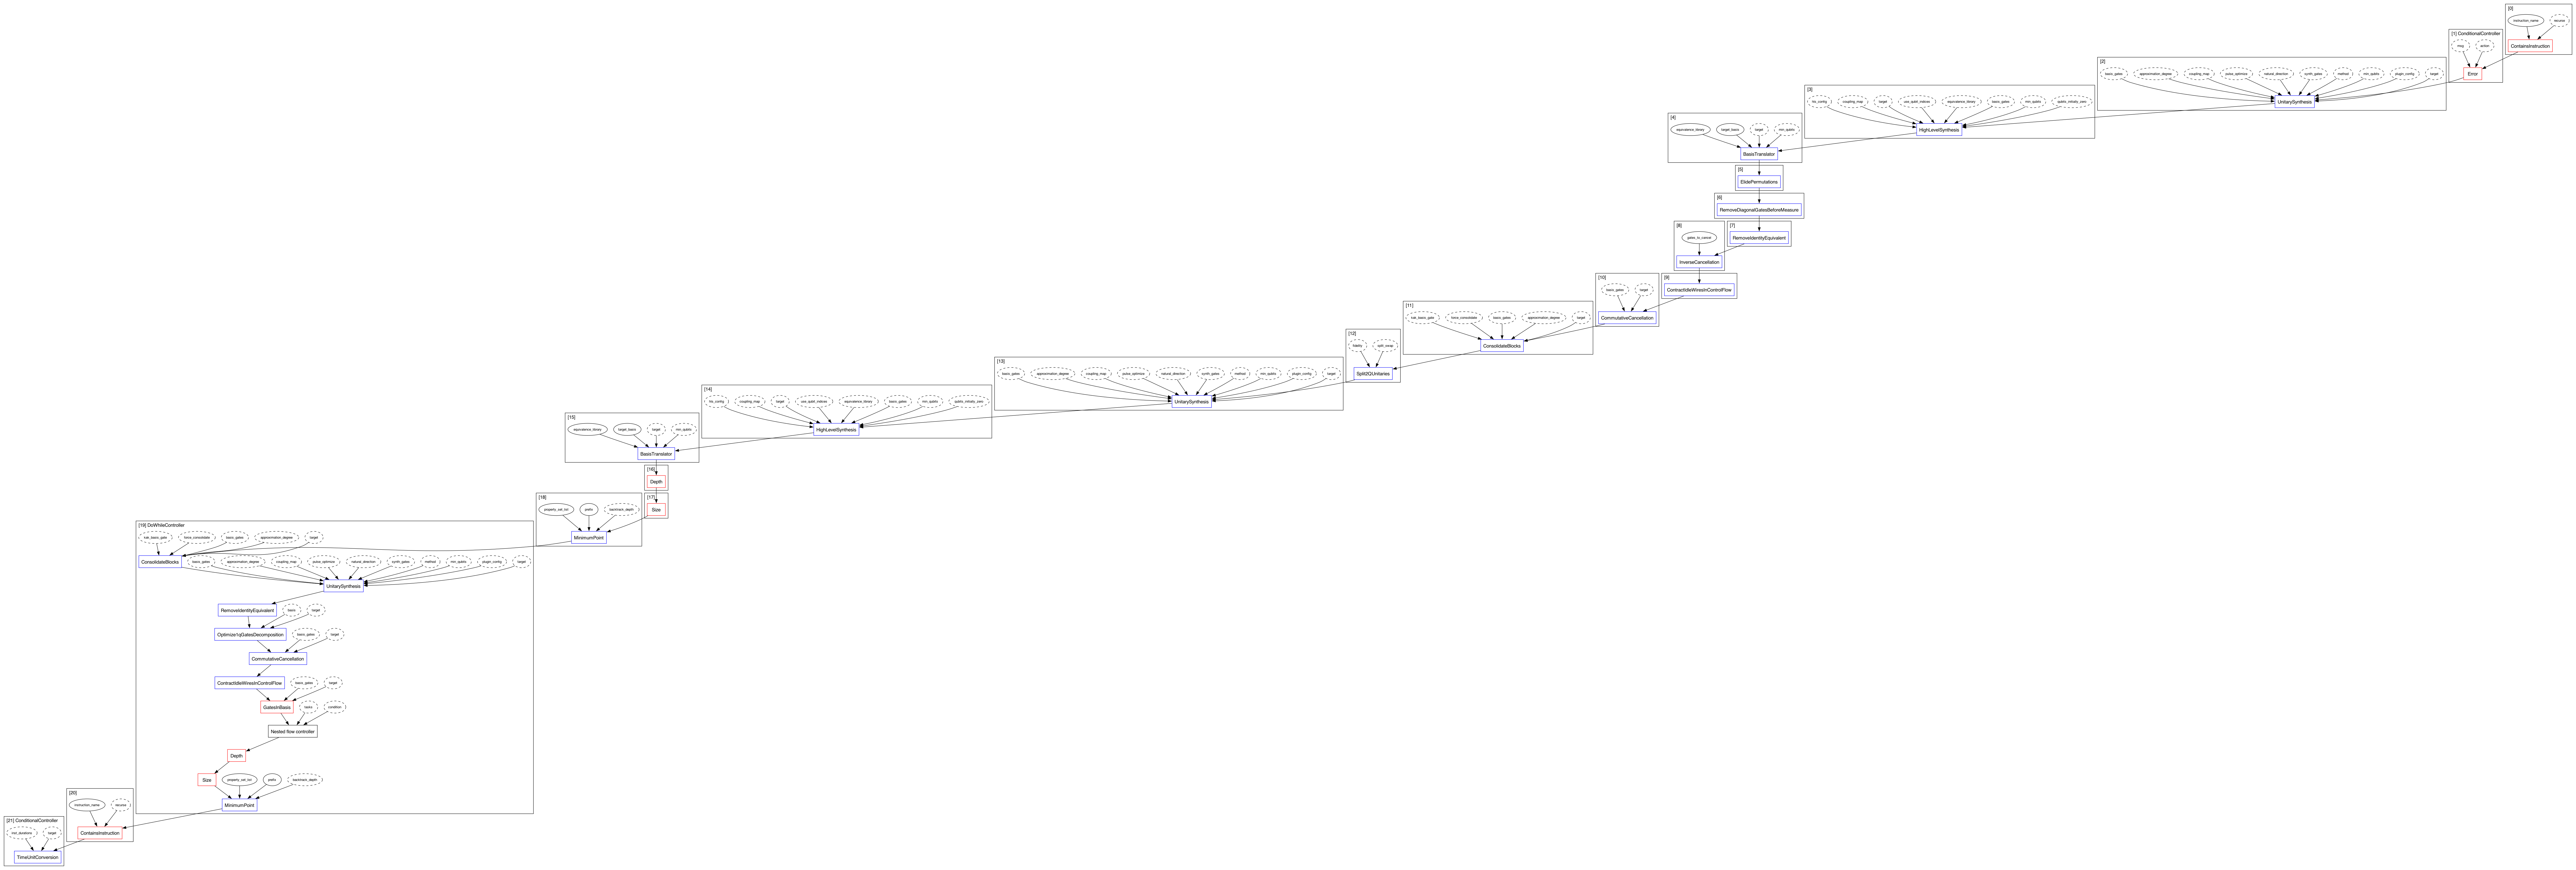

In [4]:
pm = generate_preset_pass_manager(optimization_level=3)
pass_manager_drawer(pm)

In [5]:
print(pass_manager)

In [3]:
# from qiskit_ibm_provider import IBMProvider
# provider = IBMProvider()
backend = provider.get_backend("ibmq_qasm_simulator")

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=2)
print(pass_manager)

NameError: name 'provider' is not defined

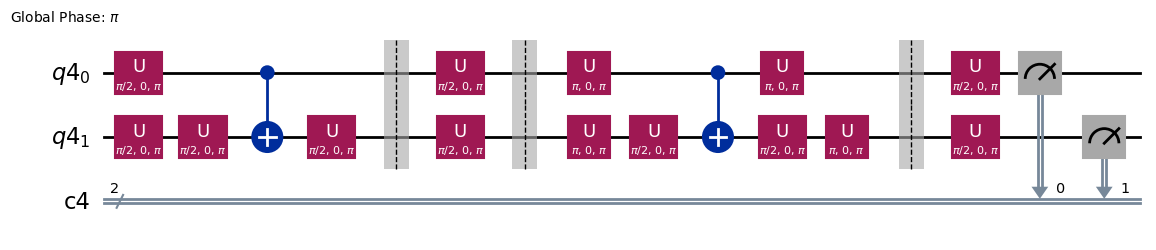

In [83]:
decomposed_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=0)
decomposed_qc.draw(output='mpl')

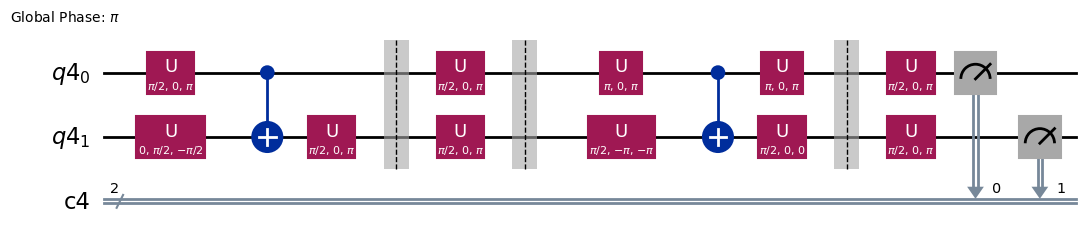

In [84]:
decomposed_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=1)
decomposed_qc.draw(output='mpl')

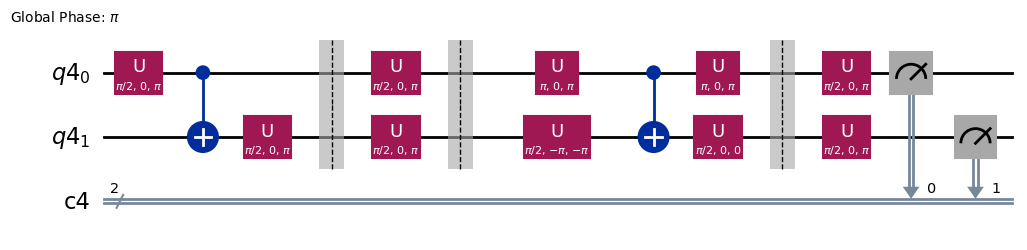

In [85]:
decomposed_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=2)
decomposed_qc.draw(output='mpl')

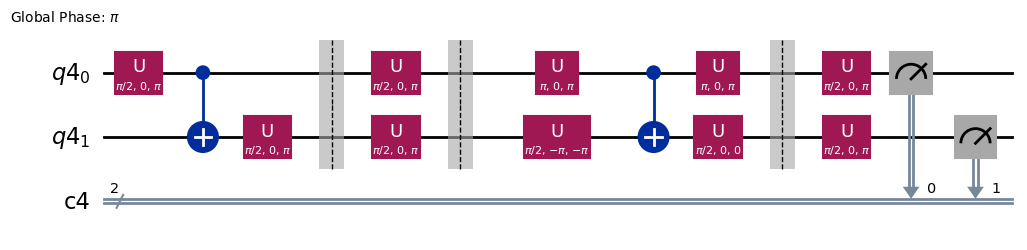

In [86]:
decomposed_qc = transpile(qc, basis_gates=['u', 'cx'], optimization_level=3)
decomposed_qc.draw(output='mpl')